#### Requirements:
* GPU based instance, ml.g4dn family
* conta_python3 kernel
* Platform identifier: [notebook-al2-v2](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi-al2.html)

In [1]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet

### To run this project, CUDA drivers need to be on version 10.2+

In [1]:
# to have cuda 10.2:
!nvcc --version
!sudo rm -rf /usr/local/cuda
!sudo ln -s /usr/local/cuda-10.2 /usr/local/cuda
!nvcc --version

# to upgrade to cuda 11
# !wget https://developer.download.nvidia.com/compute/cuda/11.4.1/local_installers/cuda_11.4.1_470.57.02_linux.run
# !echo "====> Upgrading the driver, this might take a while..."
# !sudo sh cuda_11.4.1_470.57.02_linux.run --silent --driver --toolkit
# !rm -rf cuda_11.4.1_470.57.02_linux.run
# !echo "====> Done!"
# !nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


### Now we can start running it
First let's adjust some parameters

In [3]:
%cd darknet

/home/ec2-user/SageMaker/amazon-sagemaker-notebooks/yolov4_darknet/darknet


In [4]:
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!sed -i 's/USE_CPP=0/USE_CPP=1/' Makefile

In [ ]:
!make clean
!make

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2021-09-01 08:44:23--  https://docs.google.com/uc?export=download&confirm=58fV&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 172.217.18.110, 2a00:1450:4001:803::200e
Connecting to docs.google.com (docs.google.com)|172.217.18.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-54-docs.googleusercontent.com/docs/securesc/32lo4k6cir3gqj2o68sc6jm41thev26k/29vdg0au8nuefjuevd4din7d6g8jmfdv/1630485825000/17800843676226924807/02282502120107300537Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-09-01 08:44:24--  https://doc-04-54-docs.googleusercontent.com/docs/securesc/32lo4k6cir3gqj2o68sc6jm41thev26k/29vdg0au8nuefjuevd4din7d6g8jmfdv/1630485825000/17800843676226924807/02282502120107300537Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-04-54-docs.googleusercontent.com (doc-04-54-docs.googleusercontent.com)... 142.250.184.225, 2a00:1450:4001:831::2001
Connecting to doc-

In [12]:
import urllib.request
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

In [35]:
import darknet
network, class_names, class_colors = darknet.load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = darknet.network_width(network)
height = darknet.network_height(network)

In [36]:
def infer(image_location):
    start_cloud_Img = time.time()

    req = urllib.request.urlopen(image_location)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    image = cv2.cvtColor(cv2.imdecode(arr, -1), cv2.COLOR_BGR2RGB)

    start_predict_Img = time.time()
    
    darknet_image = darknet.make_image(width, height, 3)
    img_resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

    img_height, img_width, _ = image.shape
    width_ratio = img_width / width
    height_ratio = img_height / height
    
    darknet.copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image)
    darknet.free_image(darknet_image)
    
    end_predict_Img = time.time()

    for label, confidence, bbox in detections:
        left, top, right, bottom = darknet.bbox2points(bbox)
        left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
        cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
        cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                          (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          class_colors[label], 2)

    plt.imshow(image)
    plt.show()

    end_cloud_Img = time.time()

    print(f"Processing time: {end_cloud_Img - start_cloud_Img} seconds")
    print(f"Inference time: {end_predict_Img - start_predict_Img} seconds")

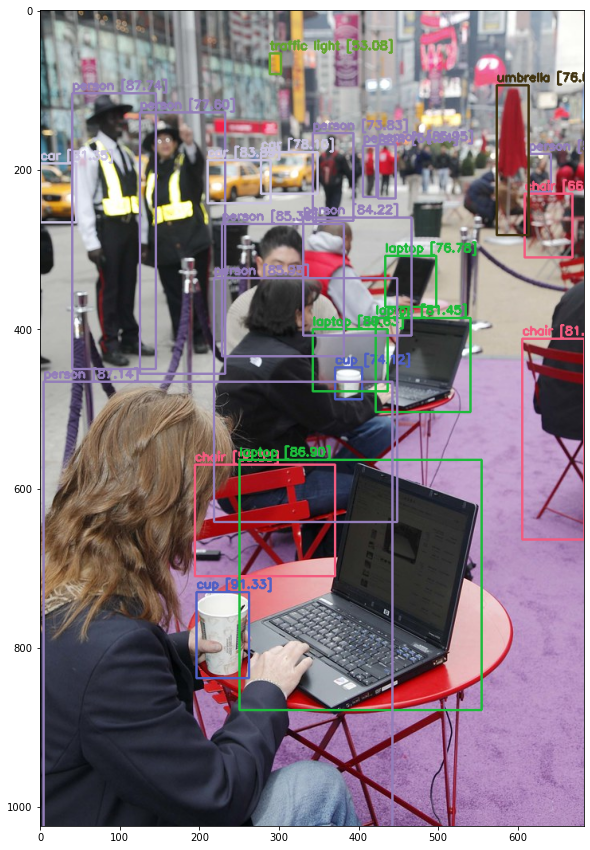

Processing time: 0.7230877876281738 seconds
Inference time: 0.04552912712097168 seconds


In [37]:
infer('https://live.staticflickr.com/2791/4092672143_b122ea69dc_b.jpg')

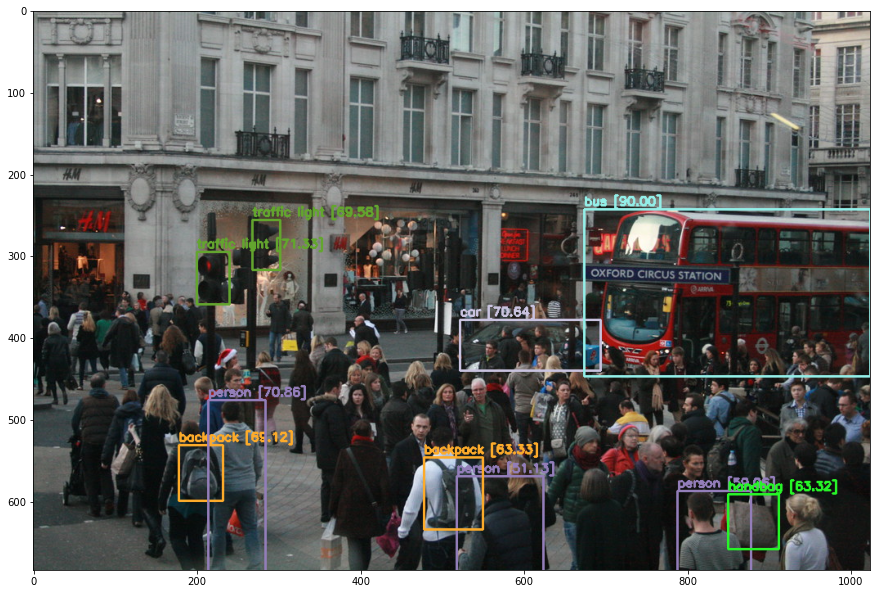

Processing time: 0.8554275035858154 seconds
Inference time: 0.041480064392089844 seconds


In [38]:
infer('https://live.staticflickr.com/7164/6492707291_9a8db89942_b.jpg')

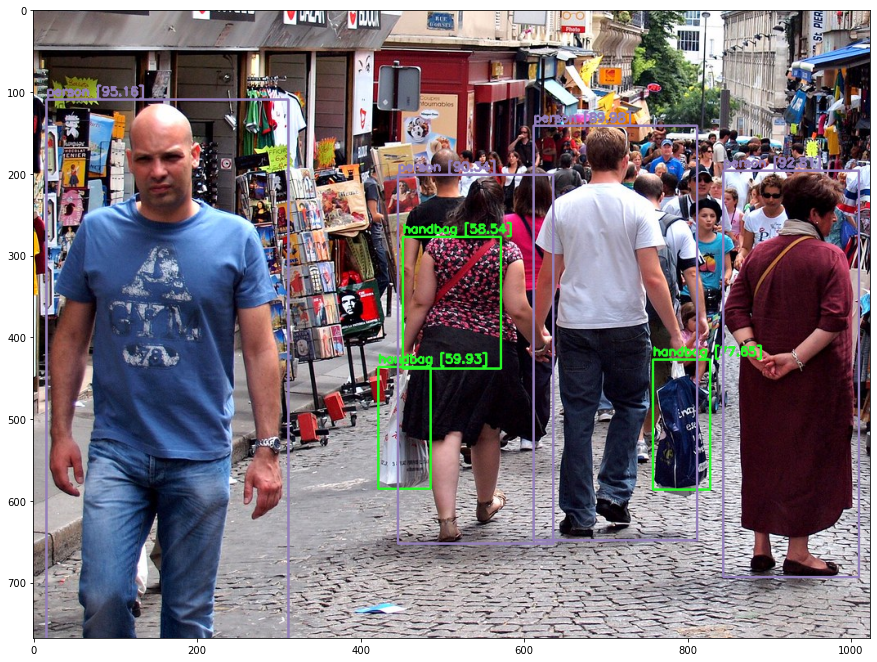

Processing time: 0.8306901454925537 seconds
Inference time: 0.041445016860961914 seconds


In [39]:
infer('https://live.staticflickr.com/4077/4857742964_8b45dfa770_b.jpg')